## Proyecto del Día 13 - Juego de Navegación en un Laberinto

Este proyecto tiene como objetivo desarrollar un entorno de laberinto simple y aplicar un algoritmo de **Aprendizaje por Refuerzo** para enseñar a una IA a navegar desde un punto inicial hasta un objetivo.

Dada la naturaleza de este proyecto, considero que el algoritmo más adecuado para este tipo de probleas es **Q-Learning**, por su facilidad de implelentación y comprensión, su estabilidad y su relación entre la exploración y la explotación.

Por esa razón te propongo resolverlo usando ese algoritmo, aunque dejo a tu criterio si quieres resolverlo con otro algoritmo de tu elección. Siempre estaré a favor de que investigues, y expandas las habilidades propuestas por tu cuenta.

### Descripción del Laberinto:

El laberinto se representa como una matriz de dos dimensiones, donde cada elemento puede ser:
+ un camino libre (0)
+ un obstáculo (1)
+ el objetivo (G)

La tarea es desarrollar un agente que pueda aprender a encontrar el camino desde un punto de inicio hasta el objetivo evitando obstáculos.


### Creación del Laberinto

Debido a que el desafío de hoy es bastante complejo, y que el objetivo final no se trata de que sepas desarrollar laberintos, sino sistemas para resolverlos, voy a facilitar la tarea entregando en este cuaderno el código para generar nuestros laberintos.

Tu parte será la siguiente, que es diseñar y entrenar un modelo de Q-Learning para resolver el laberinto de la manera mpas eficiente, y luego mostrar una visualización sobre cómo lo ha hecho.

Te deseo toda la suerte del mundo, y sobre todo, que te diviertas de a montones.

In [1]:
# Librerías necesarias para todo el ejercicio
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Función para crear el laberinto
def crear_laberinto(tamanio, porcentaje_paredes=20, inicio=(0, 0), meta=None):
    laberinto = np.zeros((tamanio, tamanio))
    numero_paredes = int((tamanio * tamanio) * porcentaje_paredes / 100)
    
    # Ubicar paredes
    for pared in range(numero_paredes):
        x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
        
        # Cuidar que inicio y meta no sean paredes
        if (x, y) != inicio and (meta is None or (x, y) != meta):
            laberinto[x, y] = 1
            
    # Ubicar la meta
    if meta:
        laberinto[meta] = 9  # Representa la meta con 9
    else:
        # Ubicar la meta aleatoriamente si no está especificado
        while True:
            x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
            if laberinto[x, y] == 0 and (x, y) != inicio:
                laberinto[x, y] = 9
                break
    
    return laberinto

In [3]:
# Función para visualizar el laberinto
def ver_laberinto(laberinto):
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    plt.colorbar();

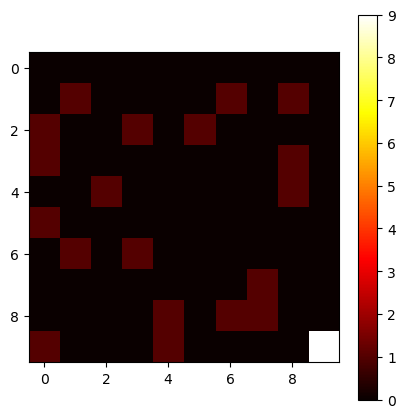

In [4]:
# Ejemplo de crear y mostrar laberintos
laberinto = crear_laberinto(10, 20, inicio=(0, 0), meta=(9, 9))
ver_laberinto(laberinto)

In [7]:
laberinto

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 9.]])

### Ahora te toca a ti

Lo que sigue es implementar todo el código para que un algoritmo de Q-Learning encuentre la manera más eficiente de llegar a la meta. Voy a dejarte los pasos que considero que son los necesarios para lograrlo

##### 1. Parámetros para el algoritmo Q-Learning

In [6]:
initial_state: tuple[int, int] = (0, 0)
goal_state: tuple[int, int] = (9, 9)

up: int = 0
down: int = 1
left: int = 2
right: int = 3

actions: dict[int, tuple[int, int]] = {
    up: (0, -1),
    down: (0, 1),
    left: (-1, 0),
    right: (1, 0),
}

In [11]:
grid_states: int = laberinto.shape[0] * laberinto.shape[1]
grid_states

100

In [12]:
possible_actions: int = len(actions)
possible_actions

4

In [13]:
def convert_state_to_index(
        state: tuple[int, int],
        grid: tuple[int, int]
        ) -> int:
    """
    Convert the current two-dimensional representation of the current
    state (the agent's position on the grid) to an unique linear index.

    Every possible state can be represented as a index number for the
    Q table.

    Parameters
    ----------
    state : tuple[int, int]
        The current two-dimensional representation of the current state
        (the agent's position on the grid).

    grid : tuple[int, int]
        The width and height of the grid.

    Returns
    -------
    int
        The index of the current state in the Q table.
    
    Examples
    --------
    >>> convert_state_to_index((0, 0), (5, 5))
    0
    >>> convert_state_to_index((4, 4), (5, 5))
    24

    """
    return state[0] * grid[1] + state[1]

In [16]:
x, y = laberinto.shape
example = convert_state_to_index((9, 9), (x, y))
example

99

In [17]:
alpha: float = 0.1      # learning rate
gamma: float = 0.99     # discount factor
epsilon: float = 0.2    # exploration
episodes: int = 100     # number of episodes

##### 2. Función para elegir acciones equilibrando entre explotación y exploración

In [18]:
def choose_action(
        Q: np.ndarray,
        state: tuple[int, int],
        actions: dict[int, tuple[int, int]],
        grid: tuple[int, int],
        epsilon: float
        ) -> int:
    """
    Choose a random action or the best action for the current state,
    depending on the exploration rate.

    Parameters
    ----------
    Q : np.ndarray
        The Q table.
    
    state : tuple[int, int]
        The current two-dimensional representation of the current state
        (the agent's position on the grid).
    
    actions : dict[int, tuple[int, int]]
        The list of possible actions.

    grid : tuple[int, int]
        The width and height of the grid.

    epsilon : float
        The exploration rate.

    Returns
    -------
    int
        A random action or the best action for the current state,
        depending on the exploration rate.
    
    Requirements
    ------------
    1. Python's built-in `random` library (`import random`).
    2. NumPy (`import numpy as np`).
    3. The `convert_state_to_index()` function declared above.        
    """
    random_number: float = random.uniform(0, 1)
    random_action: int = random.choice(list(actions.keys()))
    best_action: int = int(np.argmax(Q[convert_state_to_index(state, grid)]))

    if random_number < epsilon:
        return random_action
    return best_action

##### 3. Función para simular la acción en el laberinto

In [20]:
def apply_action(
        action: int,
        state: tuple[int, int],
        goal_state: tuple[int, int],
        grid: tuple[int, int],
        obstacles: list[tuple[int, int]]
        ) -> tuple[tuple[int, int], int, bool]:
    """
    Apply the action to the current state.

    Parameters
    ----------
    action : int
        The action to be applied.

    state : tuple[int, int]
        The current two-dimensional representation of the current state
        (the agent's position on the grid).

    goal_state : tuple[int, int]
        The two-dimensional representation of the state declared as
        goal.

    grid : tuple[int, int]
        The width and height of the grid.

    obstacles : list[tuple[int, int]]
        The list of obstacles on the grid.

    Returns
    -------
    tuple[tuple[int, int], int, bool]
        The new state, the reward, and whether the game is over.

    """
    points: int = 0
    is_game_over: bool = False

    new_state: tuple[int, int] = tuple(np.add(state, action) % grid)

    if new_state in obstacles or new_state == state:
        points = -100
        return state, points, is_game_over
    elif new_state == goal_state:
        points = 100
        is_game_over = True
        return new_state, points, is_game_over
    else:
        points = -1
        return new_state, points, is_game_over

##### 4. Función principal para ejecutar el algoritmo Q-Learning

In [21]:
def update_Q_values(
        Q: np.ndarray,
        state_index: int,
        action_index: int,
        alpha: float,
        gamma: float,
        new_state_index: int,
        reward: int,
        ) -> float:
    """
    Update the Q values for the current state and action.

    Parameters
    ----------
    Q : np.ndarray
        The Q table.

    state_index : tuple[int, int]
        The index of the current state in the Q table.

    action_index : int
        The index of the current action in the Q table.

    alpha : float
        The learning rate.

    gamma : float
        The discount factor.

    new_state_index : tuple[int, int]
        The index of the new state in the Q table.

    reward : int
        The reward for the current state and action.

    Returns
    -------
    float
        The updated Q value.
    """
    current_q = Q[state_index, action_index]
    best_future_q = np.max(Q[new_state_index])
    return current_q + alpha * (reward + (gamma * best_future_q) - current_q)

##### 5. Función para convertir coordenadas a índice lineal

##### 6. Iniciar el laberinto y configurar el algoritmo Q-Learning

##### 7. Función para mostrar el aprendizaje del agente

##### 8. Visualizar el resultado